<a href="https://colab.research.google.com/github/Satvika1825/pothole-detection/blob/main/EmoTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras opencv-python

In [1]:
from google.colab import files
import zipfile, os

# Upload the FER-2013 zip file manually
uploaded = files.upload()

# Assuming your file name is fer2013.zip
zip_path = list(uploaded.keys())[0] # Get the name of the uploaded file
extract_path = "/content/fer2013"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted at:", extract_path)
print("📁 Folders:", os.listdir(extract_path))

Saving facial_emotions.zip to facial_emotions.zip
✅ Dataset extracted at: /content/fer2013
📁 Folders: ['test', 'train']


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [3]:
train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96,96),  # upscale for VGG16
    color_mode="rgb",      # converts grayscale → 3 channels
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(96,96),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))

# Freeze base layers for feature extraction
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,087 (65.15 MB)

 Trainable params: 2,363,399 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30 # initial top-layer training
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 113s 118ms/step - accuracy: 0.3319 - loss: 1.7471 - val_accuracy: 0.4372 - val_loss: 1.4665
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 102s 113ms/step - accuracy: 0.3946 - loss: 1.5579 - val_accuracy: 0.4606 - val_loss: 1.4138
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 100s 111ms/step - accuracy: 0.4108 - loss: 1.5240 - val_accuracy: 0.4617 - val_loss: 1.3985
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 99s 110ms/step - accuracy: 0.4231 - loss: 1.4994 - val_accuracy: 0.4595 - val_loss: 1.3890
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 100s 112ms/step - accuracy: 0.4324 - loss: 1.4795 - val_accuracy: 0.4776 - val_loss: 1.3934
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 100s 112ms/step - accuracy: 0.4443 - loss: 1.4616 - val_accuracy: 0.4759 - val_loss: 1.3783
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 97s 108ms/step - accuracy: 0.4473 - loss: 1.4414 - val_accuracy: 0.4801 - val_loss: 1.3595
Epoch 8/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 98s 110ms/step - accuracy: 0.4502 - lo

In [6]:
# Unfreeze last 10 convolutional layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Callbacks
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Compile with smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=45,  # fine-tuning
    callbacks=[es, rlr]
)


Epoch 1/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 132s 137ms/step - accuracy: 0.4828 - loss: 1.3540 - val_accuracy: 0.5432 - val_loss: 1.1987 - learning_rate: 1.0000e-05
Epoch 2/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 118s 131ms/step - accuracy: 0.5313 - loss: 1.2400 - val_accuracy: 0.5517 - val_loss: 1.1595 - learning_rate: 1.0000e-05
Epoch 3/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 117s 130ms/step - accuracy: 0.5528 - loss: 1.1822 - val_accuracy: 0.5750 - val_loss: 1.1148 - learning_rate: 1.0000e-05
Epoch 4/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 115s 128ms/step - accuracy: 0.5668 - loss: 1.1496 - val_accuracy: 0.5804 - val_loss: 1.1216 - learning_rate: 1.0000e-05
Epoch 5/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 115s 128ms/step - accuracy: 0.5877 - loss: 1.1033 - val_accuracy: 0.5958 - val_loss: 1.0564 - learning_rate: 1.0000e-05
Epoch 6/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 115s 128ms/step - accuracy: 0.5935 - loss: 1.0775 - val_accuracy: 0.6070 - val_loss: 1.0458 - learning_rate: 1.0000e-05
Epoch 7/45
898/898 ━━━━━━━━━━━━━━━━━━━━ 

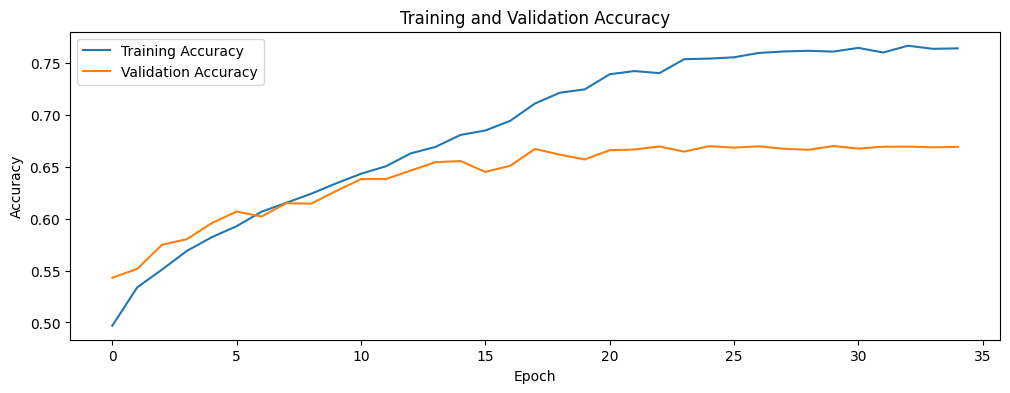

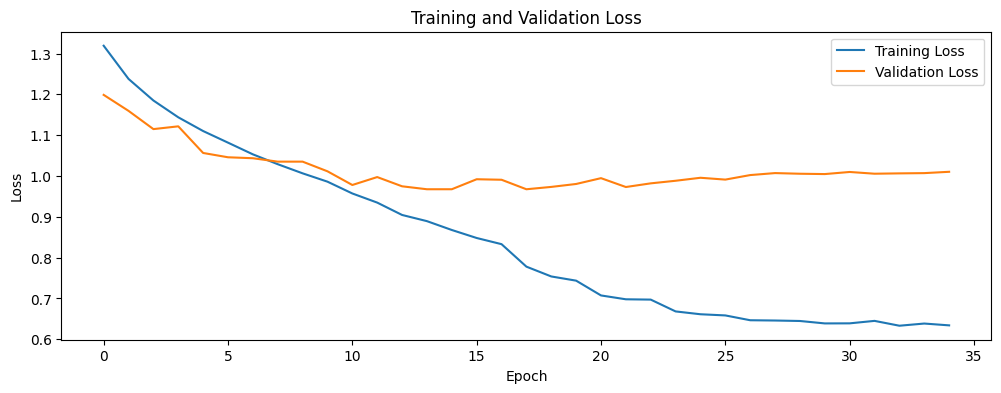

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
model.save("fer2013_vgg16.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [23]:
from google.colab import files
files.download("fer2013_vgg16.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving PublicTest_96538817.jpg to PublicTest_96538817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


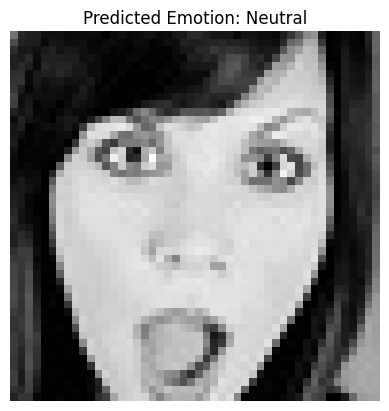

In [20]:
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt

# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


# Upload an image
uploaded = files.upload()

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (96,96))   # Change to (48,48) or (224,224) if your model used that
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Predict
pred = model.predict(img)
pred_label = emotion_labels[np.argmax(pred)]

# Show result
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Emotion: {pred_label}")
plt.axis('off')
plt.show()